In [33]:
"""
Analyze NN predictions. This is hacky code to get predictions to Claudio fast. 
Peter July 12 2023

"""

import os
from collections import defaultdict
import numpy as np
import h5py
import matplotlib.pyplot as plt

import keras_core as keras

#import tensorflow_io as tfio
from tensorflow.data import Dataset
from tensorflow.data.experimental import AUTOTUNE

import preprocess

%load_ext autoreload
%autoreload 2


# Create dataset object using IODataset
polarity = 'neg'
path = '/mnt/lts/nfs_fs02/sadow_lab/shared/gcr/data/2023_07_01/'
f = f'{path}/{polarity}/model_collection_1AU_90deg_0deg_fixed_training.h5'
# 8 input parameters for the NN: alpha, cmf, vspoles, cpa, pwr1par, pwr2par, pwr1perr, and pwr2perr.
#features = ['alpha', 'cmf', 'cpa', 'pwr1par', 'pwr1perr', 'pwr2par', 'pwr2perr', 'vspoles']
N = 1000  # Just get a subset for testing
with h5py.File(f, 'r') as h5:
    #num_samples, num_inputs,  = h5['X_minmax'].shape
    #_, num_flux,  = h5['Y_log_scaled'].shape
    num_samples = N
    x = h5['/X_minmax'][:N, ...]
    y = h5['Y_log_scaled'][:N,...]
# x = tfio.IODataset.from_hdf5(f, dataset='/X_minmax')
# y = tfio.IODataset.from_hdf5(f, dataset='/Y_log_scaled')

# Split
full = Dataset.from_tensor_slices((x, y))
#full = Dataset.zip((x, y))
train = full.take(np.floor(num_samples *.9))#.repeat()
test = full.skip(np.floor(num_samples *.9))#.repeat()

# Batch
BATCH_SIZE = 128
train = train.batch(BATCH_SIZE, drop_remainder=True).prefetch(AUTOTUNE)
test = test.batch(BATCH_SIZE, drop_remainder=True).prefetch(AUTOTUNE)

# Some calcs
steps_per_epoch = int(num_samples * .9 / BATCH_SIZE )
validation_steps = int(num_samples * .1 / BATCH_SIZE)
print(f'Steps per epoch: {steps_per_epoch}')

model_path = f'../models/model_v1.0_{polarity}.keras'  # Must end with keras.
model = keras.models.load_model(model_path)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Steps per epoch: 7


In [38]:
npi = train.as_numpy_iterator()
xbatch = npi.next()
yhat = model.predict(xbatch)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


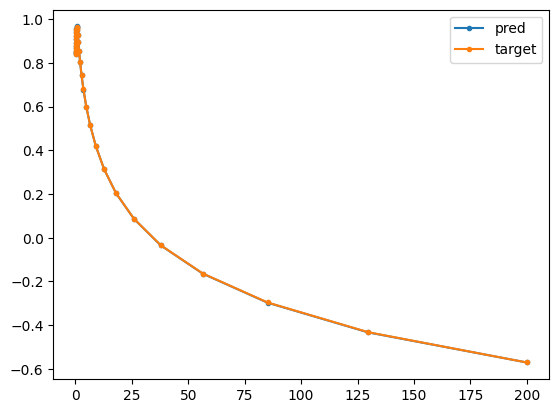

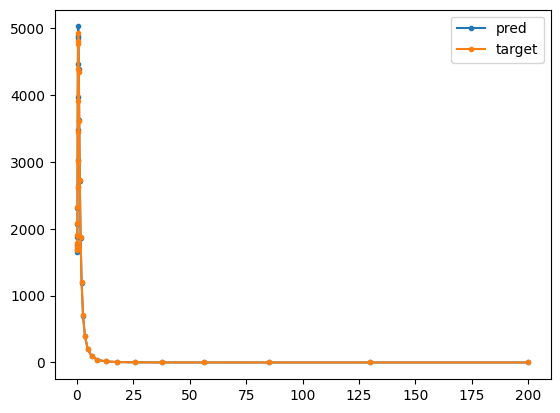

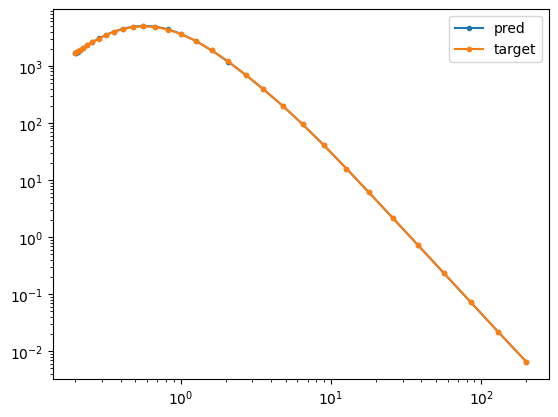

In [39]:
import matplotlib.pyplot as plt
import utils

plt.plot(preprocess.RIGIDITY_VALS, yhat[0,:], marker='.', label='pred')
plt.plot(preprocess.RIGIDITY_VALS, y[0,:], marker='.', label='target')
plt.legend()

plt.figure(2)
plt.plot(preprocess.RIGIDITY_VALS, utils.untransform_output(yhat[0,:]), marker='.', label='pred')
plt.plot(preprocess.RIGIDITY_VALS, utils.untransform_output(y[0,:]), marker='.', label='target')
plt.legend()

plt.figure(3)
plt.loglog(preprocess.RIGIDITY_VALS, utils.untransform_output(yhat[0,:]), marker='.', label='pred')
plt.loglog(preprocess.RIGIDITY_VALS, utils.untransform_output(y[0,:]), marker='.', label='target')
plt.legend()

In [33]:
# Quick check of paredictions.
N = 1
print(yhat[:N, :])
print(Y[:N,:])
print(trainset[:N])
print(metadata['quality'][:N])
print(X_minmax[:N])


[[1.06897728e+02 1.09673195e+02 1.16209541e+02 1.25315056e+02
  1.43295715e+02 1.67029953e+02 1.98731354e+02 2.46567688e+02
  3.09029297e+02 3.91782898e+02 5.04324951e+02 6.44143311e+02
  8.05205566e+02 9.85203247e+02 1.13972607e+03 1.21198193e+03
  1.14415308e+03 9.44869263e+02 6.86349426e+02 4.37492035e+02
  2.58357605e+02 1.33430969e+02 6.42946243e+01 2.77195663e+01
  1.08660107e+01 4.18909931e+00 1.51157510e+00 5.27836978e-01
  1.73729241e-01 5.68317994e-02 1.76857505e-02 6.50129607e-03]]
[[1.08284531e+02 1.11323494e+02 1.17628922e+02 1.27677155e+02
  1.46093491e+02 1.71169281e+02 2.04915222e+02 2.56114258e+02
  3.24251160e+02 4.13785675e+02 5.39576233e+02 6.97150818e+02
  8.83545288e+02 1.09432202e+03 1.27094714e+03 1.34427783e+03
  1.25773022e+03 1.02853918e+03 7.46904968e+02 4.77308441e+02
  2.84326569e+02 1.48361359e+02 7.23004379e+01 3.14299583e+01
  1.23511438e+01 4.74311495e+00 1.69762433e+00 5.87181091e-01
  1.90945834e-01 6.02606162e-02 1.84793100e-02 6.50727283e-03]]
[ Tr

(array([    0.,  2023., 31535., 34441., 20392.]),
 array([   0.,  500., 1000., 1500., 2000., 2500.]),
 <BarContainer object of 5 artists>)

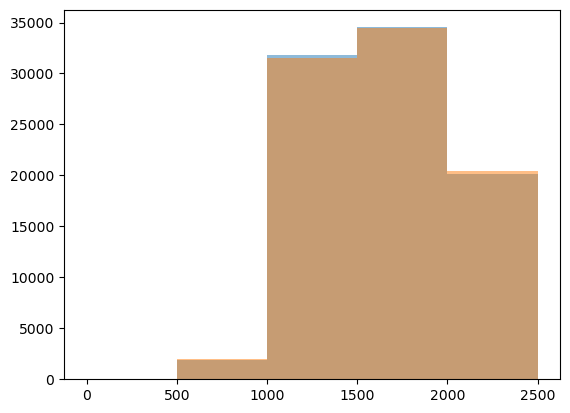

In [29]:
import matplotlib.pyplot as plt
N = 100000
i=16
bins = np.arange(0, 3000, 500)
plt.hist(yhat[:N, i], bins=bins, alpha=0.5,  label='pred')
plt.hist(Y[:N, i], bins=bins, alpha=0.5, label='true')

In [16]:
yhat.shape

(2851200, 32)

In [15]:
yhat[0, :N].shape

(32,)